In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/massil/repos/newsvendor_tester


In [2]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from environment import *
from algorithms.ddm import DDM_algorithm
from algorithms.rcosd_adaptive_volume_constrained import RCOSD_Adaptive_Volume_Constrained_algorithm
from algorithms.cosd_adaptive_volume_constrained import COSD_Adaptive_Volume_Constrained_algorithm
from simulator import Simulator

from tqdm import tqdm

### Defining the demand process
Here we define a non-perishable environment such that $n=3$, $T=2000$ and $d_{t,i} \sim \text{Poisson}(\lambda_i)$ where $\lambda_1=25, \lambda_2=15, \lambda_3=10$, with losses $\ell_t(y) = h^T(y-d_t)_+ + p^T (d_t-y)_+$.

Notice that in this example $\rho=1$

In [3]:
nb_products = 3
horizon = 10_000
holding_costs = np.ones(nb_products)
penalty_costs = 50*np.ones(nb_products)

def env_generator() :
    demands = np.zeros((horizon+1,nb_products))
    demands[1:,0] = scipy.stats.poisson(25).rvs(size=(horizon))
    demands[1:,1] = scipy.stats.poisson(15).rvs(size=(horizon))
    demands[1:,2] = scipy.stats.poisson(10).rvs(size=(horizon))
    #demands[1:,3] = scipy.stats.poisson(1).rvs(size=(horizon))
    return Environment_NonPerishable_Newsvendor(demands, holding_costs, penalty_costs)

In [4]:
#np.quantile(env_generator().demands[1:], penalty_costs/(holding_costs+penalty_costs), axis=0)
for i in range(nb_products) :
    print(np.quantile(env_generator().demands[1:,i], penalty_costs[i]/(holding_costs[i]+penalty_costs[i])))

36.0
23.0
17.0


Plotting a demand realizations and histogram

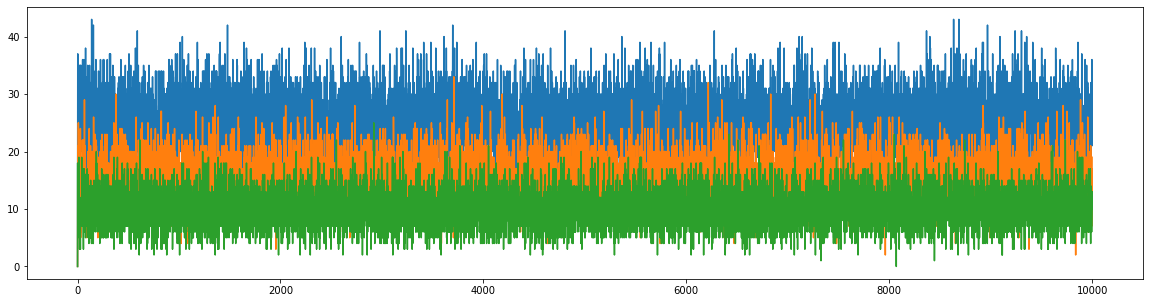

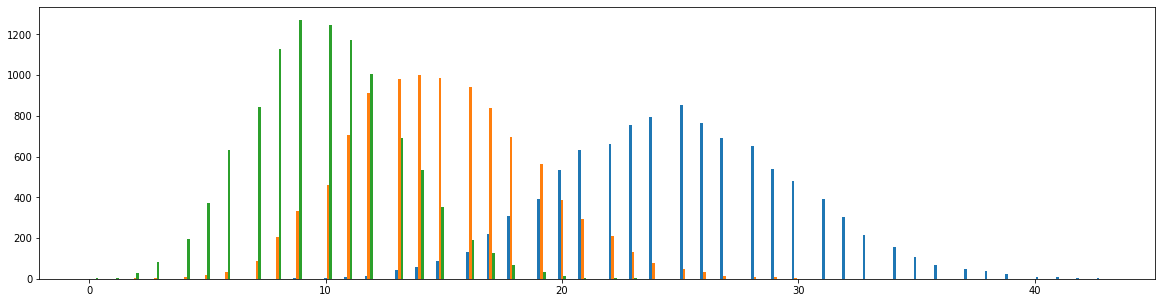

In [5]:
demands_example = env_generator().demands
plt.figure(figsize=(20,5))
plt.plot(demands_example)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(demands_example,bins=100)
plt.show()

### Defining the algorithms

The box constraint, the hyperparameter $\gamma\leq \rho/D$ and the gradients' norm upper bound $G$

In [6]:
volumes = np.ones(nb_products)
total_volume = 80
diameter = np.minimum(total_volume*np.sqrt(2)/np.min(volumes), total_volume*np.sqrt(np.sum(1/volumes**2)))
gamma = 1/diameter
G = np.sqrt(nb_products)*np.max(np.maximum(holding_costs,penalty_costs))

The algorithms

In [7]:
nb_algs = 3
initial_decision = np.array([1,1,1])
algs = [
    COSD_Adaptive_Volume_Constrained_algorithm(initial_decision,volumes,total_volume,gamma),
    RCOSD_Adaptive_Volume_Constrained_algorithm(initial_decision,volumes,total_volume,gamma),
    DDM_algorithm(initial_decision,volumes,total_volume,gamma,G,holding_costs,penalty_costs)
]

Building the simulator which wraps the main loop

In [8]:
nb_samples = 10
horizons = np.linspace(10,horizon,100).astype(int)

sim = Simulator(env_generator, nb_products, nb_samples, horizons, algs,
    lambda optimum : np.sum(volumes*optimum)<=total_volume, holding_costs, penalty_costs)
cum_losses = sim.run()

100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


In [9]:
for i in range(nb_algs) :
    print("Alg {} ({}) final regret: {}, final regret std: {}".format(
        i,
        algs[i],
        np.mean((cum_losses[:,i+1,-1]-cum_losses[:,0,-1])),
        np.std(cum_losses[:,i+1,-1]-cum_losses[:,0,-1])
        #np.std(np.sum(losses[:,i+1,:],axis=1)-np.sum(losses[:,0,:],axis=1))
    ))

Alg 0 (COSD $\gamma=0.008838834764831844$) final regret: 322596.13161269494, final regret std: 4782.6273129085885
Alg 1 (RCOSD $\gamma=0.008838834764831844$) final regret: 362618.03074421856, final regret std: 4632.80967095296
Alg 2 (DDM $\gamma=0.008838834764831844$) final regret: 420940.23063610855, final regret std: 4898.09013845183


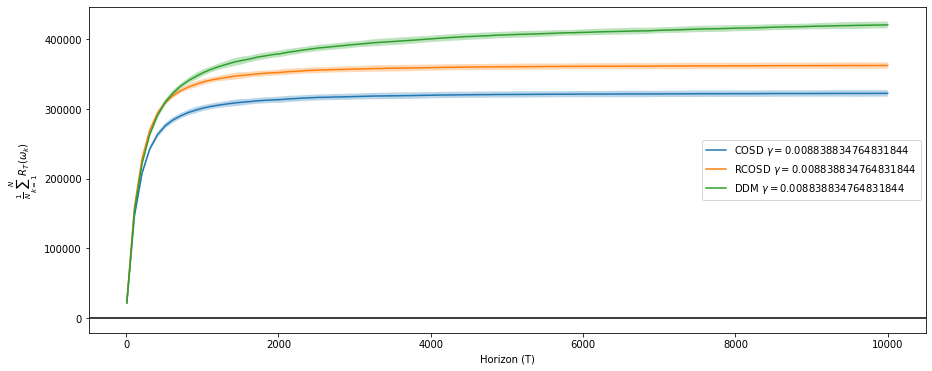

In [10]:
plt.figure(figsize=(15,6))
for i in range(nb_algs) :
    y = np.mean(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    std = np.std(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    plt.plot(horizons, y,label=algs[i])
    plt.fill_between(horizons, y-std,y+std,alpha=0.3)
plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,np.sqrt(horizons)*D/(4*np.sqrt(2)),"x",color="k",label="theoretical lower bound")
plt.ylabel(r"$\frac{1}{N}\sum_{k=1}^N R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend()
plt.show()

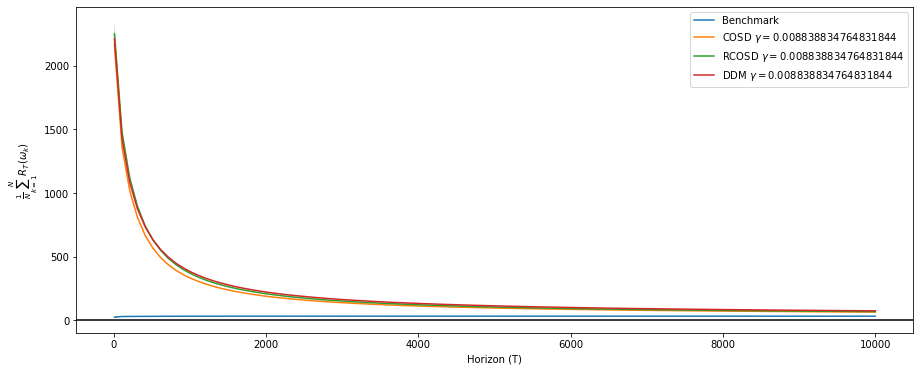

In [11]:
plt.figure(figsize=(15,6))
for i in range(nb_algs+1) :
    y = np.mean(cum_losses[:,i,:], axis=0)/horizons
    std = np.std(cum_losses[:,i,:], axis=0)/horizons
    plt.plot(horizons, y,label= "Benchmark" if i==0 else algs[i-1])
    plt.fill_between(horizons, y-std,y+std,alpha=0.3)
plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,np.sqrt(horizons)*D/(4*np.sqrt(2)),"x",color="k",label="theoretical lower bound")
plt.ylabel(r"$\frac{1}{N}\sum_{k=1}^N R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend()
plt.show()